In [1]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf

In [2]:
df=pd.read_csv(os.path.join('train_data_cleaned.csv'))

In [3]:
data=df.replace({'OFF':1,'NOT_OFF':0,'HS':1,'NOT_HS':0})

In [4]:
data.tail()

,Tweet,Offensive,Hate
6995,يا حمار يا جاهل نسبه الباطل ما بتحسبش و عاملي...,1,0
6996,كل زق يا طاقيه يا واطي يا حقير يا تافه يا ساف...,1,0
6997,يا كبير يا متع يا نجم لابد ان تعي جيدا انا ما...,0,0
6998,يا رب الاتحاد يفوز يا رب 😭 الاتحاد النصر,0,0
6999,يعز عليا ادخل الشارع وملاقيكش واقف مستنيني في ...,0,0


In [5]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.3.0
aiohttp                       3.8.3
aiosignal                     1.2.0
alabaster                     0.7.12
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
async-timeout                 4.0.2
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcr

In [6]:
from tensorflow.keras.layers import TextVectorization


In [7]:
X = data['Tweet']
y = data[data.columns[1:]].values

In [8]:
y.shape

(7000, 2)

In [9]:
data[data.columns[1:]]

,Offensive,Hate
0,0,0
1,0,0
2,1,1
3,0,0
4,0,0
...,...,...
6995,1,0
6996,1,0
6997,0,0
6998,0,0


In [10]:
MAX_FEATUERS=6000

In [11]:
vectorizer=TextVectorization(max_tokens=MAX_FEATUERS,output_sequence_length=900,output_mode='int')

In [12]:
vectorizer.adapt(X.values)

In [13]:
vectorizer('حبيبي يا ربنا')

<tf.Tensor: shape=(900,), dtype=int64, numpy=
array([26,  2, 47,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

In [14]:
vectorized_text = vectorizer(X.values)

In [15]:
vectorized_text

<tf.Tensor: shape=(7000, 900), dtype=int64, numpy=
array([[ 338,   25, 1836, ...,    0,    0,    0],
       [5166,    2, 2641, ...,    0,    0,    0],
       [   2,    8,    2, ...,    0,    0,    0],
       ...,
       [   2,   81,    2, ...,    0,    0,    0],
       [   2,    8,   61, ...,    0,    0,    0],
       [   1,  346,    1, ...,    0,    0,    0]], dtype=int64)>

In [16]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(7100)
dataset = dataset.batch(2)
dataset = dataset.prefetch(8)

In [17]:
dataset.as_numpy_iterator().next()

(array([[  2, 122, 530, ...,   0,   0,   0],
        [ 15,  61,  89, ...,   0,   0,   0]], dtype=int64),
 array([[1, 1],
        [0, 0]], dtype=int64))

In [18]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [20]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATUERS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer 
model.add(Dense(2, activation='sigmoid'))

In [21]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')


In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          192032    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                        

In [23]:
history = model.fit(train, epochs=15,validation_data=val)


Epoch 1/10
2450/2450 [==============================] - 921s 375ms/step - loss: 0.2808 - val_loss: 0.1571
Epoch 2/10
2450/2450 [==============================] - 915s 374ms/step - loss: 0.1821 - val_loss: 0.1256
Epoch 3/10
2450/2450 [==============================] - 917s 374ms/step - loss: 0.1376 - val_loss: 0.1024
Epoch 4/10
2450/2450 [==============================] - 917s 374ms/step - loss: 0.1158 - val_loss: 0.0943
Epoch 5/10
2450/2450 [==============================] - 917s 374ms/step - loss: 0.0946 - val_loss: 0.0786
Epoch 6/10
2450/2450 [==============================] - 924s 377ms/step - loss: 0.0758 - val_loss: 0.0523
Epoch 7/10
2450/2450 [==============================] - 921s 376ms/step - loss: 0.0574 - val_loss: 0.0367
Epoch 8/10
2450/2450 [==============================] - 930s 380ms/step - loss: 0.0415 - val_loss: 0.0496
Epoch 9/10
2450/2450 [==============================] - 937s 382ms/step - loss: 0.0332 - val_loss: 0.0397
Epoch 10/10
2450/2450 [=======================

In [79]:
from matplotlib import pyplot as plt


<Figure size 800x500 with 0 Axes>

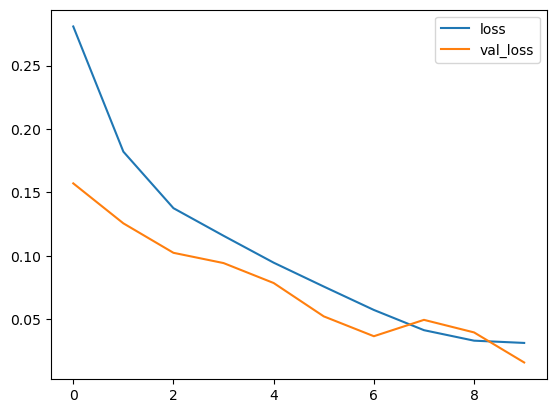

In [80]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [81]:
input_text = vectorizer('اشكال زباله ونصابين ربنا ياخدهم الفاسدين')


In [82]:
model.predict(np.array([input_text]))

1/1 [==============================] - 0s 101ms/step


array([[9.9987650e-01, 2.7830226e-04]], dtype=float32)

In [83]:
res= model.predict(np.array([input_text]))

1/1 [==============================] - 0s 95ms/step


In [84]:
(res > 0.5).astype(int)


array([[1, 0]])

In [85]:
batch_X, batch_y = test.as_numpy_iterator().next()


In [86]:
(model.predict(batch_X) > 0.5).astype(int)


1/1 [==============================] - 0s 133ms/step


array([[0, 0],
       [0, 0]])

In [87]:
res.shape


(1, 2)

In [88]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [89]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [90]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 134ms/step


In [91]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9941860437393188, Recall:0.9553072452545166, Accuracy:0.6428571343421936


In [92]:
!pip install gradio jinja2


In [93]:
import tensorflow as tf
import gradio as gr

In [94]:
model.save('ahmeddd')

INFO:tensorflow:Assets written to: ahmeddd\assets


INFO:tensorflow:Assets written to: ahmeddd\assets


In [95]:
model = tf.keras.models.load_model('ahmeddd')


In [96]:
input_str = vectorizer('حبيبي يا ربنا')


In [97]:
res = model.predict(np.expand_dims(input_str,0))


1/1 [==============================] - 1s 1s/step


In [98]:
res

array([[9.2301234e-06, 8.1582185e-11]], dtype=float32)

In [99]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[1:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [100]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                        outputs='text')

C:\Users\Hamama\anaconda3\lib\site-packages\gradio\inputs.py:26: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
C:\Users\Hamama\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Hamama\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
C:\Users\Hamama\anaconda3\lib\site-packages\gradio\deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


In [101]:
interface.launch(share=True)


Thanks for being a Gradio user! If you have questions or feedback, please join our Discord server and chat with us: https://discord.gg/feTf9x3ZSB
Running on local URL:  http://127.0.0.1:7863
Running on public URL: https://213963158dee004e.gradio.app

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


(<gradio.routes.App at 0x27953ca5b80>,
 'http://127.0.0.1:7863/',
 'https://213963158dee004e.gradio.app')